In [1]:
%%script false --no-raise-error
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%%script false --no-raise-error
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/


# Ejercicio 2.2: Face Recognition

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar una solucion para reconocimiento de facial. Se proveen datos de entrenamiento y es necesario entrenar un clasificador para hacer el reconocimiento. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



In [3]:
import cv2 
import numpy as np
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
import sys
import scipy.io



### Cargar Datos de Entrenamiento y Validación


In [4]:
data_dir='./data'
face_recognition_dir = os.path.join(data_dir, 'face_recognition')
training_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_tr.mat')
validation_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_va.mat')


testing_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_te.mat')

In [5]:
training_data_mat = scipy.io.loadmat(training_data_file)
validation_data_mat = scipy.io.loadmat(validation_data_file)
testing_data_mat = scipy.io.loadmat(testing_data_file)

In [6]:
training_data=training_data_mat['tr_img_sample']
validation_data = validation_data_mat['va_img_sample']

testing_data = testing_data_mat['va_img_sample']

### Esqueleto de funciones para extracción de Features

In [7]:
from skimage.feature import local_binary_pattern, hog


class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, img):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(img)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(img)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(img)	
	
	return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
	resized_image = cv2.resize(img,resize_size)
	image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
	return image_representation
  
def extract_lbp_features(img):
    # https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern
    # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
    try:
        # settings for LBP
        radius = LBP_CONFIG['radius']
        n_points = LBP_CONFIG['n_points'] * LBP_CONFIG['radius']
        METHOD = LBP_CONFIG['METHOD']
    except NameError as e:
            radius, n_points, METHOD = 3, 8, 'uniform'
                    
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    
    width, height = lbp.shape
    
    CELL_SIZE = 16
    BINS = 10
    
    quantity_cells_w, quantity_cells_h = int(width/CELL_SIZE), int(height/CELL_SIZE)
    
    histograms = np.zeros((quantity_cells_w, quantity_cells_h, BINS))
    
    for i in range(0, quantity_cells_w):
        for j in range(0, quantity_cells_h):
            top_border, bottom_border = i*CELL_SIZE, (i+1)*CELL_SIZE
            left_border, right_border = j*CELL_SIZE, (j+1)*CELL_SIZE
            histogram, bins = np.histogram(lbp[top_border:bottom_border, left_border:right_border])
            histograms[i, j] = histogram
    
    sum_of_histograms = np.ravel(histograms).flatten()
    return sum_of_histograms

def extract_hog_features(img):
    # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
    hog_repr = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), feature_vector=True)
    return hog_repr

def extract_sift_features(img):
#     https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img)
    return descriptors

### Armar los datos de entrenamiento y sus etiquetas

In [8]:
%%script false --no-raise-error
training_images = []
training_labels = []
for training_image in training_data:
    image = (training_image[0]/255)
    label = training_image[2]
    training_images.append(image.reshape(64*64))
    training_labels.append(label.reshape(1))

training_images = np.asarray(training_images)
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape(training_labels.shape[0])

In [9]:
%%script false --no-raise-error
plt.imshow(training_data[0][0].reshape(64,64), cmap='gray')

### Construir datos de validación y sus etiquetas


In [10]:
%%script false --no-raise-error
validation_images = []
validation_labels = []
validation_names = []
for validation_image in validation_data:
    image = (validation_image[0]/255)
    label = validation_image[2] 
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image.reshape(64*64))
    validation_labels.append(label.reshape(1))
    validation_names.append(name)

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])

In [11]:
%%script false --no-raise-error
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,algorithm='brute')
knn_classifier.fit(training_images,training_labels)

In [12]:
from sklearn.svm import SVC

# kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# C = 1
# chosen_kernel = kernel[0]

def train_SVM(C, kernel, x, y):
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # teniendo en cuenta que decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’
    # es decir, por defecto es one versus rest
    # no hay que hacer nada especial
    svm = SVC(C=C, kernel=kernel, probability=True, degree=4, gamma=3)
    svm.fit(x, y)
    return svm

#### Guardar Modelo Entrenado

In [13]:
%%script false --no-raise-error
pickle.dump(knn_classifier,open('./face_recogition', 'wb'))

#### Cargar modelo

In [14]:
%%script false --no-raise-error
classifier = pickle.load(open('./face_recogition','rb'))

### Clasificar los datos de validación


In [15]:
%%script false --no-raise-error
labels = classifier.predict(validation_images)
## Get score for each sliding window patch
scores = classifier.predict_proba(validation_images)

###  Evaluar modelo de Reconocimento

In [16]:
%%script false --no-raise-error
acc = np.mean(labels==validation_labels)*100

In [17]:
%%script false --no-raise-error
print('The accuracy of face recognition is:%.2f \n' % acc)


### Visualize Recognition ###

In [18]:
%%script false --no-raise-error
indexes = [13,50,77,18,110] # You can use Random Sample
for index in indexes:
    predicted_label=labels[index]
    real_label = validation_labels[index]

    pred_name = validation_names[np.nonzero(validation_labels==predicted_label)[0][0]]
    real_name = validation_names[np.nonzero(validation_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(validation_images[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()


### Searching Hyperparameters

In [19]:

def load_training_data(training_data, feature_extractor):
    training_images = []
    training_labels = []
    for training_image in training_data:
        image = (training_image[0]/255)
        label = training_image[2]
        training_repr = extract_features(feature_extractor, image)
        
        training_images.append(training_repr)
        training_labels.append(label.reshape(1))

    training_images = np.asarray(training_images)
    training_labels = np.asarray(training_labels)
    training_labels = training_labels.reshape(training_labels.shape[0])
    
    return training_images, training_labels
    
    
    
def load_validation_data(validation_data, feature_extractor):
    validation_images = []
    validation_labels = []
    validation_names = []
    for validation_image in validation_data:
        image = (validation_image[0]/255)
        label = validation_image[2] 
        name = validation_image[1][0].split('.')[0]
        
        validation_repr = extract_features(feature_extractor, image)
        validation_images.append(validation_repr)
        validation_labels.append(label.reshape(1))
        validation_names.append(name)

    validation_images = np.asarray(validation_images)
    validation_labels = np.asarray(validation_labels)
    validation_labels = validation_labels.reshape(validation_labels.shape[0])
    
    return validation_images, validation_labels

In [20]:
%%script false --no-raise-error
C = [0.01, 0.1, 0.5, 1, 2, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

accs = []

feature_extractors = [
     FeatureExtractors.MiniImage,
     FeatureExtractors.LBP,
     FeatureExtractors.HOG
][::-1]

for feature_extractor in feature_extractors:
    print('loading')
    training_repr, training_labels = load_training_data(training_data, feature_extractor)
    validation_repr, validation_labels = load_validation_data(validation_data, feature_extractor)


    for k in kernel:
        for c in C:

    #         print(f'started training C {c:3} kernel {k:8}, fe {feature_extractor}')
            print(f'started training C {c:3} kernel {k:8}')
            classifier = train_SVM(c, k, training_repr, training_labels)
            print('finished training')

            print('starting validation')
            labels = classifier.predict(validation_repr)
            print('ending validation')

            acc = np.mean(labels==validation_labels)*100
            print(f'\nC {float(c):3} kernel {k:8} fe {feature_extractor} - Detection Average Precision is {float(acc):12}%')
            accs.append([acc, feature_extractor, c, k])
            
accs

In [21]:
%%script false --no-raise-error
from operator import itemgetter

sorted(accs, key=itemgetter(0))

In [22]:
%%script false --no-raise-error

pickle.dump(accs,open(f'./accuracy-face-recognition-no-feature-extractor', 'wb'))

In [23]:
%%script false --no-raise-error
# para cada label, agarro todas sus fotos. Para cada foto, calculo sus descriptores.
# ahora, tenemos para cada label sus descriptores. Hago kmeans sobre TODOS los descriptores, codebook
# para cada imagen, agarro sus features, hallo a qué cluster pertenece cada uno, y hago histograma
# ese histograma es el vector de entrada al svm


def build_codebook():
    pass

## Searching Hyperparameters v2

Luego de sugerencia de modificar parámetro cells_per_block de HOG de (1, 1) a (4, 4), y cambiar gamma y degree de SVM a gamma=3 y degree=4, todo mejora:

In [24]:
%%script false --no-raise-error
from sklearn.svm import SVC

def train_SVM(C, kernel, x, y):
    svm = SVC(C=C, kernel=kernel, probability=True, degree=4, gamma=3)
    svm.fit(x, y)
    return svm


C = [0.01, 0.1, 0.5, 1, 2, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

accs2 = []

feature_extractors = [
     FeatureExtractors.MiniImage,
     FeatureExtractors.LBP,
     FeatureExtractors.HOG
][::-1]

for feature_extractor in feature_extractors:
    print('loading')
    training_repr, training_labels = load_training_data(training_data, feature_extractor)
    validation_repr, validation_labels = load_validation_data(validation_data, feature_extractor)


    for k in kernel:
        for c in C:

    #         print(f'started training C {c:3} kernel {k:8}, fe {feature_extractor}')
            print(f'started training C {c:3} kernel {k:8}')
            classifier = train_SVM(c, k, training_repr, training_labels)
            print('finished training')

            print('starting validation')
            labels = classifier.predict(validation_repr)
            print('ending validation')

            acc = np.mean(labels==validation_labels)*100
            print(f'\nC {float(c):3} kernel {k:8} fe {feature_extractor} - Detection Average Precision is {float(acc):12}%')
            accs2.append([acc, feature_extractor, c, k])
            
accs2

In [25]:
%%script false --no-raise-error
from operator import itemgetter

sorted(accs2, key=itemgetter(0))

### Final Training

In [26]:
C = 5
kernel = 'poly'

feature_extractor = FeatureExtractors.HOG

training_repr, training_labels = load_training_data(training_data, feature_extractor)

print(f'started training C {C:3} kernel {kernel:8}, fe {feature_extractor}')
classifier = train_SVM(C, kernel, training_repr, training_labels)
print('finished training')

started training C   5 kernel poly    , fe FeatureExtractors.HOG
finished training


### Final Validation

In [27]:

validation_repr, validation_labels = load_validation_data(validation_data, feature_extractor)

print('starting validation')
labels = classifier.predict(validation_repr)
print('ending validation')

acc = np.mean(labels==validation_labels)*100
print(f'\nC {float(C):3} kernel {kernel:8} fe {feature_extractor} - Detection Average Precision is {float(acc):12}%')

starting validation
ending validation

C 5.0 kernel poly     fe FeatureExtractors.HOG - Detection Average Precision is 47.74774774774775%


### Final Testing

In [28]:
testing_repr, testing_labels = load_validation_data(testing_data, feature_extractor)

print('starting validation')
labels = classifier.predict(testing_repr)
print('ending validation')

acc = np.mean(labels==testing_labels)*100
print(f'\nC {float(C):3} kernel {kernel:8} fe {feature_extractor} - Detection Average Precision is {float(acc):12}%')

starting validation
ending validation

C 5.0 kernel poly     fe FeatureExtractors.HOG - Detection Average Precision is 45.751633986928105%


### DEMO

#### Validación

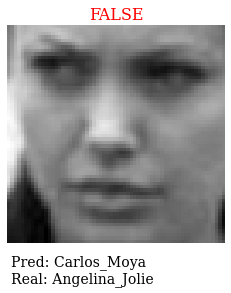

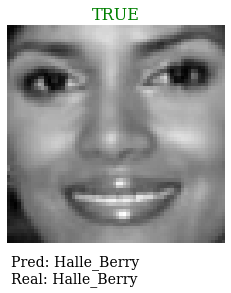

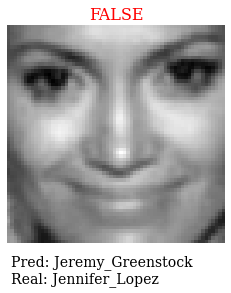

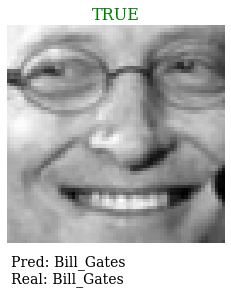

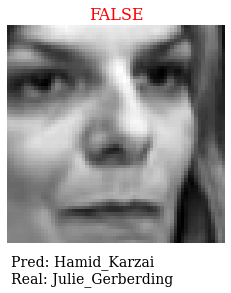

In [29]:
validation_images = []
validation_labels = []
validation_names = []
for validation_image in validation_data:
    image = (validation_image[0]/255)
    label = validation_image[2] 
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image.reshape(64*64))
    validation_labels.append(label.reshape(1))
    validation_names.append(name)

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])


labels = classifier.predict(validation_repr)
## Get score for each sliding window patch
scores = classifier.predict_proba(validation_repr)

indexes = [13,50,77,18,110] # You can use Random Sample
for index in indexes:
    predicted_label=labels[index]
    real_label = validation_labels[index]

    pred_name = validation_names[np.nonzero(validation_labels==predicted_label)[0][0]]
    real_name = validation_names[np.nonzero(validation_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(validation_images[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()


#### Testing

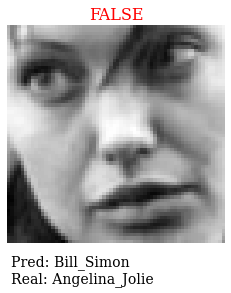

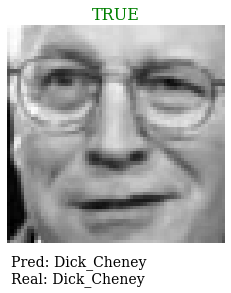

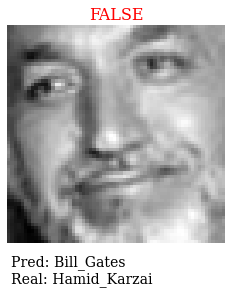

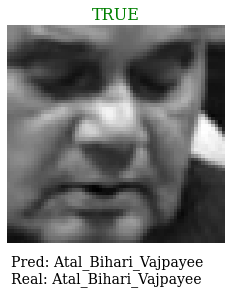

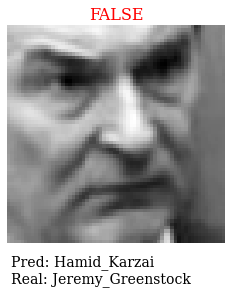

In [30]:
testing_images = []
testing_labels = []
testing_names = []
for testing_image in testing_data:
    image = (testing_image[0]/255)
    label = testing_image[2] 
    name = testing_image[1][0].split('.')[0]
    testing_images.append(image.reshape(64*64))
    testing_labels.append(label.reshape(1))
    testing_names.append(name)

testing_images = np.asarray(testing_images)
testing_labels = np.asarray(testing_labels)
testing_labels = testing_labels.reshape(testing_labels.shape[0])


labels = classifier.predict(testing_repr)
## Get score for each sliding window patch
scores = classifier.predict_proba(testing_repr)

indexes = [13,50,77,18,110] # You can use Random Sample
for index in indexes:
    predicted_label=labels[index]
    real_label = testing_labels[index]

    pred_name = testing_names[np.nonzero(testing_labels==predicted_label)[0][0]]
    real_name = testing_names[np.nonzero(testing_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(testing_images[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()
